## Import libraries and USE GPU

In [1]:
from pandas import read_csv
from numpy import set_printoptions
from sklearn import datasets, linear_model
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf
import numpy as np
import pathlib

# Using GPU
import os
import scipy.io as scpy

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'  # Set to -1 if CPU should be used CPU = -1 , GPU = 0

gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
elif cpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        logical_cpus= tf.config.experimental.list_logical_devices('CPU')
        print(len(cpus), "Physical CPU,", len(logical_cpus), "Logical CPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


2022-10-20 14:37:02.955173: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-20 14:37:03.095620: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-20 14:37:03.144487: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-20 14:37:03.599177: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

1 Physical GPUs, 1 Logical GPUs


2022-10-20 14:37:04.123116: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-20 14:37:04.153478: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-20 14:37:04.153607: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-20 14:37:04.154901: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

### Prepare Dataset

In [2]:
from pandas import read_csv
from numpy import set_printoptions
from sklearn import datasets, linear_model
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import random
# Using GPU
import os
import scipy.io as scpy

data = scpy.loadmat("all-data.mat")
# Extracting x_train from the mat file dictionary.
x_data = data["XTrain"]
# Extracting y_train from the mat file dictionary.
y_data = data["y_train"]
# Converting x_train and y_train to a numpy array.
x_data = np.array(x_data,dtype='float32')
y_data = np.array(y_data,dtype='int32')-1
x_temp_data=data['XTest']
y_temp_data=data['y_test']
x_temp_data=np.array(x_temp_data,dtype='float32')
y_temp_data=np.array(y_temp_data,dtype='int32')-1
y_temp_data=np.ravel(y_temp_data)
# x_data=np.concatenate((x_data,x_temp_data),axis=0)
# y_data=np.concatenate((y_data,y_temp_data),axis=0)

# Verifying the shapes.
print(x_data.shape)
print(y_data.shape)

SEED = 99
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
# split into train test sets
x_train, x_val_to_use, y_train, y_val_to_use = train_test_split(x_data, y_data, test_size=0.3, random_state=SEED)
x_val, x_test, y_val, y_test = train_test_split(x_val_to_use, y_val_to_use, test_size=0.5, random_state=SEED)
y_train=np.ravel(y_train)
y_val=np.ravel(y_val)
y_test=np.ravel(y_test)
print(f" {len(x_train), len(x_val), len(x_test)}")
print(f" {len(y_train), len(y_val), len(y_test)}")
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
BATCH_SIZE = 64
# SHUFFLE_BUFFER_SIZE = 100
train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)


(15000, 1000)
(15000, 1)
 (10500, 2250, 2250)
 (10500, 2250, 2250)


### Define AutoKeras Model Pipeline

In [4]:
x_tensile = x_train[np.where(y_train == 0)[0]]
y_tensile = y_train[np.where(y_train == 0)[0]]
x_shear = x_train[np.where(y_train == 1)[0]]
y_shear = y_train[np.where(y_train == 1)[0]]
x_mixed = x_train[np.where(y_train == 2)[0]]
y_mixed = y_train[np.where(y_train == 2)[0]]
from python_speech_features import mfcc
from python_speech_features import logfbank
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.subplots(nrows=3, ncols=5, figsize=(30, 30))
for i in range(1,6):
    mfcc_feat = mfcc(x_tensile[i], 5e3)
    mfcc_data= np.swapaxes(mfcc_feat, 0 ,1)
    cax = plt.subplot(3, 5, i)
    cax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
    cax.set_title('Tensile MFCC')
#############################################
    mfcc_feat = mfcc(x_shear[i], 5e3)
    mfcc_data= np.swapaxes(mfcc_feat, 0 ,1)
    cax = plt.subplot(3, 5, i+5)
    cax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
    cax.set_title('Shear MFCC')

#############################################
    mfcc_feat = mfcc(x_mixed[i], 5e3)
    mfcc_data= np.swapaxes(mfcc_feat, 0 ,1)
    cax = plt.subplot(3, 5, i+10)
    cax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
    cax.set_title('Mixed MFCC')
plt.tight_layout()
plt.show()


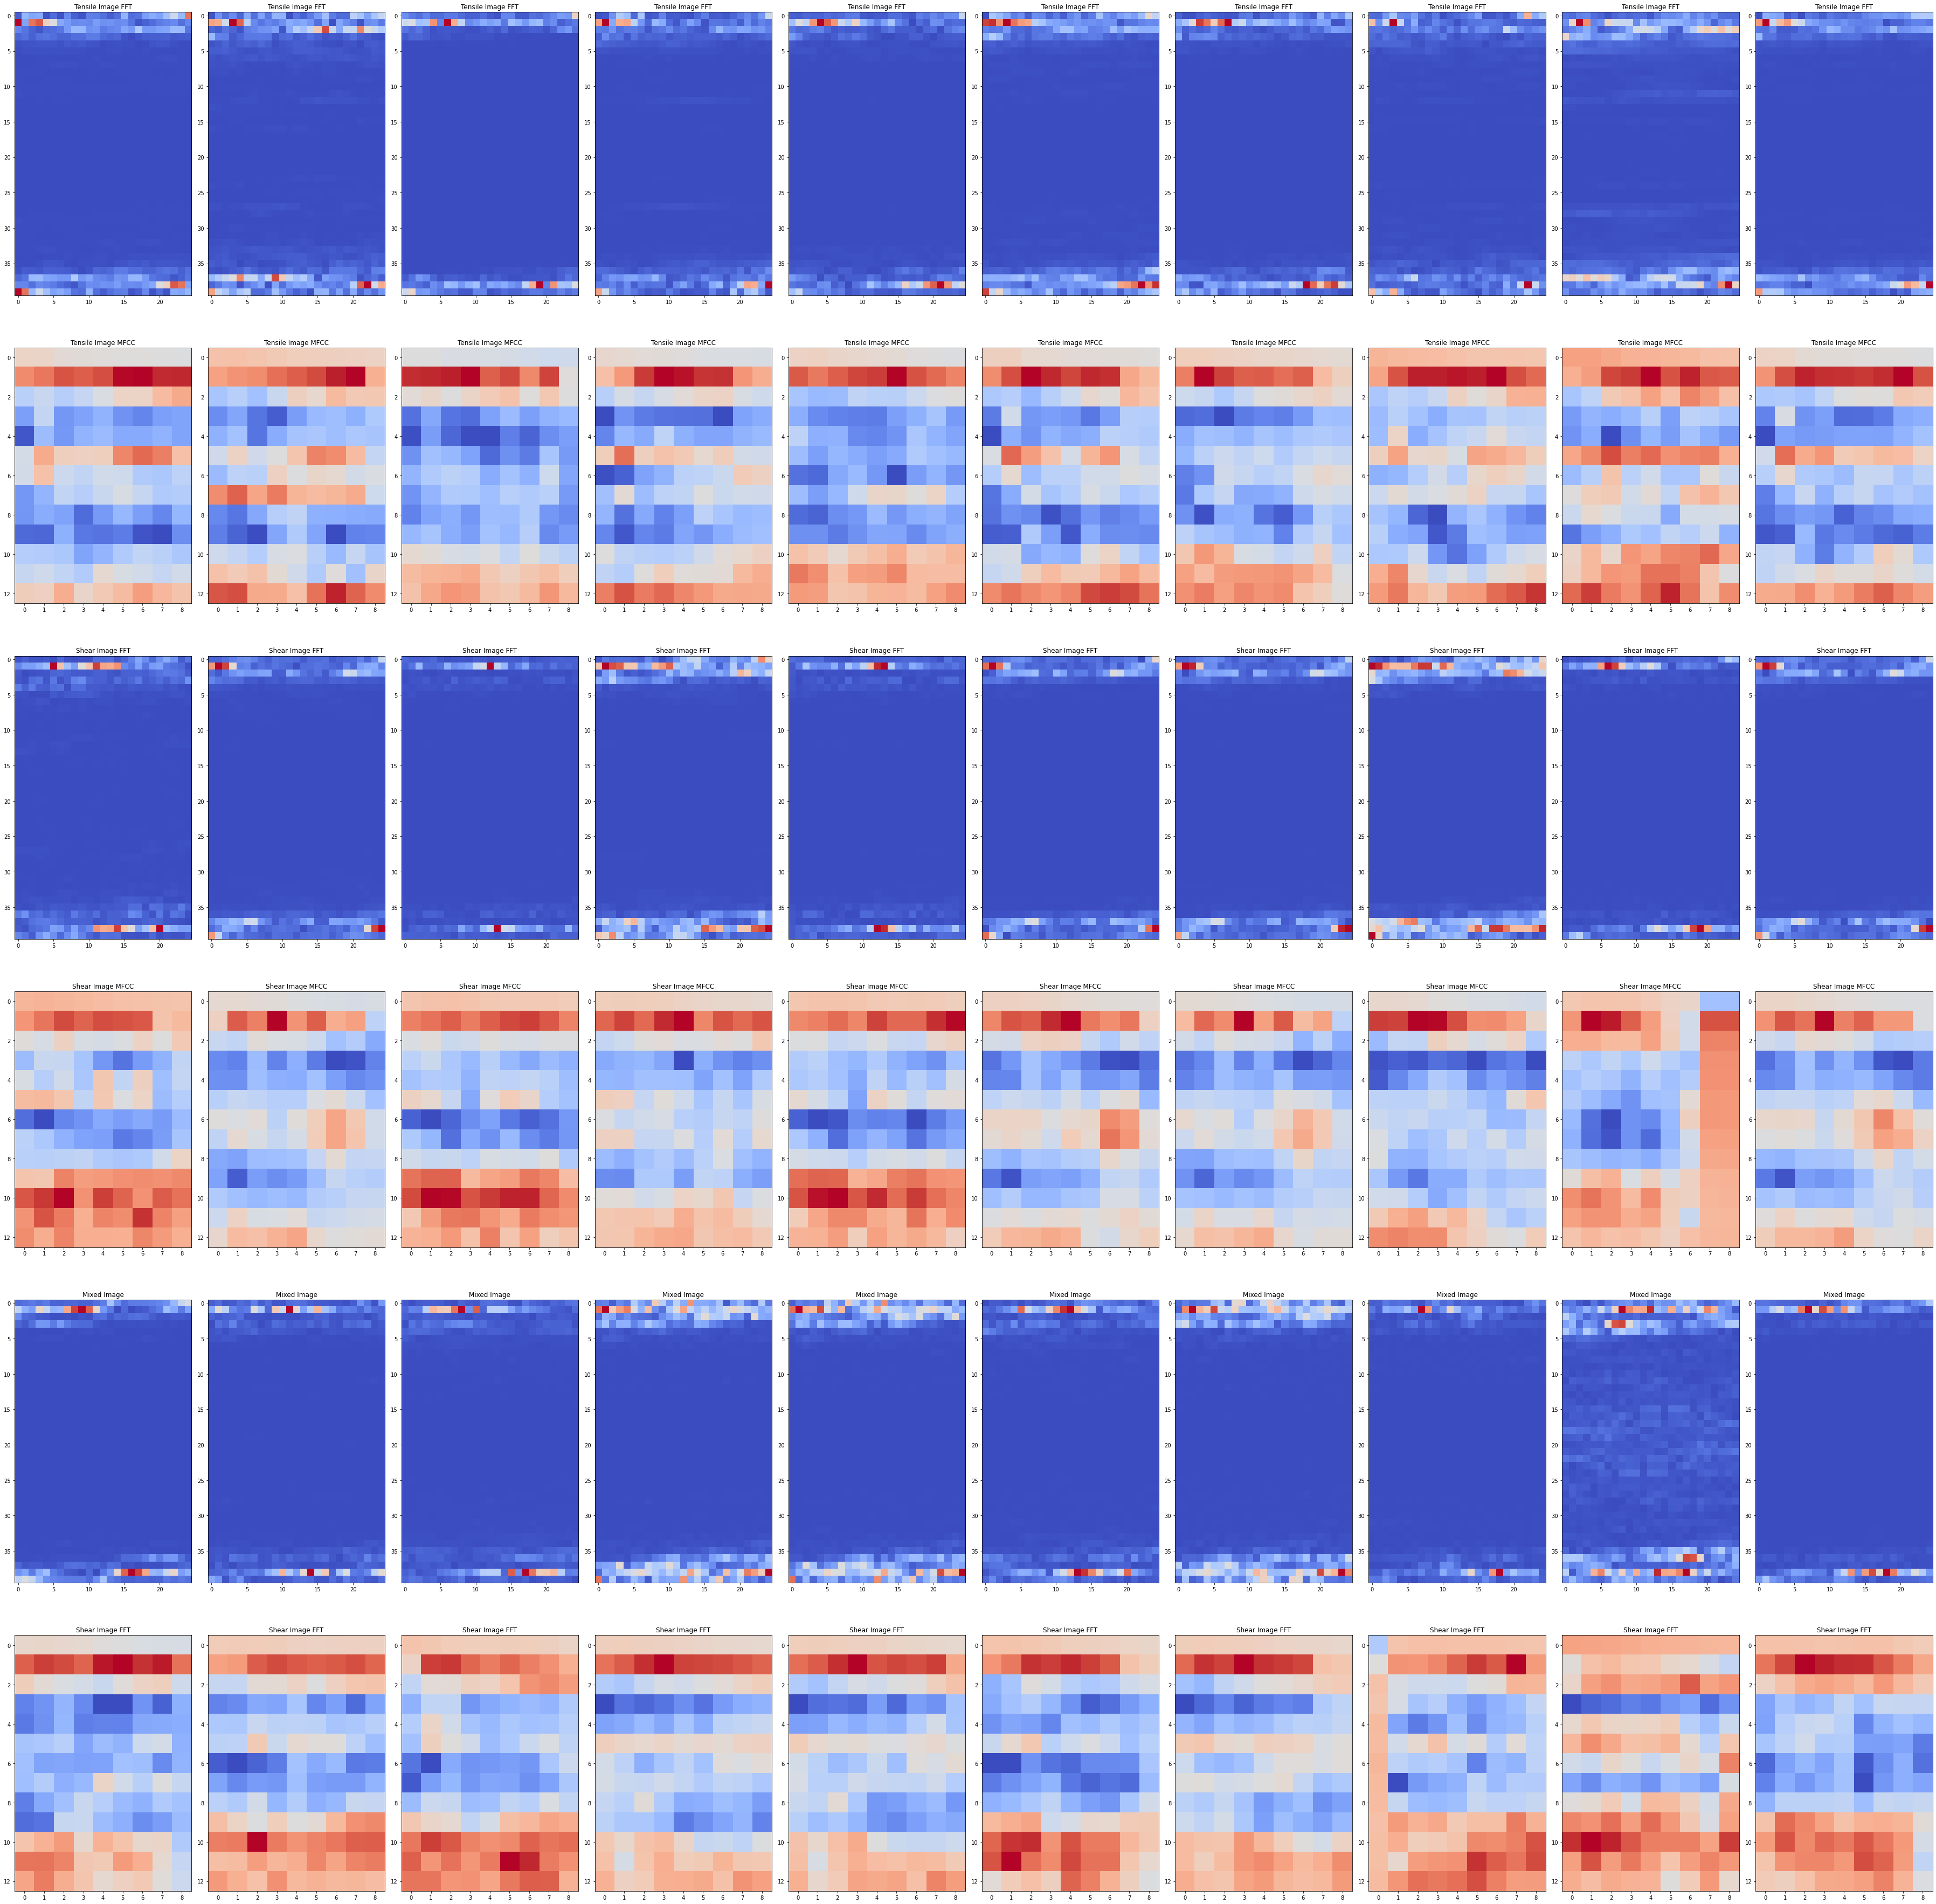

In [37]:
x_tensile = x_train[np.where(y_train == 0)[0]]
y_tensile = y_train[np.where(y_train == 0)[0]]
x_shear = x_train[np.where(y_train == 1)[0]]
y_shear = y_train[np.where(y_train == 1)[0]]
x_mixed = x_train[np.where(y_train == 2)[0]]
y_mixed = y_train[np.where(y_train == 2)[0]]
from turtle import color
from python_speech_features import mfcc
from python_speech_features import logfbank
import matplotlib.pyplot as plt
from matplotlib import cm


colormap = cm.gray
n_rows=6
n_cols=10
image_height = 40
image_width = 25



fig = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(50, 50))
for i in range(1,n_cols+1):
    x1 = np.reshape(np.abs(np.fft.fft(x_tensile[i])), (image_height, image_width))
    x2 = np.swapaxes(mfcc(x_tensile[i], 1e4), 0 ,1)
    x3 = np.reshape(np.abs(np.fft.fft(x_shear[i])), (image_height, image_width))
    x4 = np.swapaxes(mfcc(x_shear[i], 1e4), 0 ,1)
    x5 = np.reshape(np.abs(np.fft.fft(x_mixed[i])), (image_height, image_width))
    x6 = np.swapaxes(mfcc(x_mixed[i], 1e4), 0 ,1)
    data_to_plot = x1
    cax = plt.subplot(n_rows, n_cols, i)
    cax.imshow(data_to_plot ,  cmap=colormap)
    cax.set_title('Tensile Image FFT')
#############################################
    data_to_plot = x2
    cax = plt.subplot(n_rows, n_cols, i+n_cols)
    cax.imshow(data_to_plot ,  cmap=colormap)
    cax.set_title('Tensile Image MFCC')

#############################################
    data_to_plot = x3
    cax = plt.subplot(n_rows, n_cols, i+2*n_cols)
    cax.imshow(data_to_plot , cmap=colormap)
    cax.set_title('Shear Image FFT')
#############################################
    data_to_plot = x4
    cax = plt.subplot(n_rows, n_cols, i+3*n_cols)
    cax.imshow(data_to_plot , cmap=colormap)
    cax.set_title('Shear Image MFCC')    
#############################################
    data_to_plot = x5
    cax = plt.subplot(n_rows, n_cols, i+4*n_cols)
    cax.imshow(data_to_plot , cmap=colormap)
    cax.set_title('Mixed Image')
##############################################
    data_to_plot = x6
    cax = plt.subplot(n_rows, n_cols, i+5*n_cols)
    cax.imshow(data_to_plot , cmap=colormap)
    cax.set_title('Shear Image FFT')    
plt.tight_layout()
plt.show()



In [34]:
import numpy as np
import pandas as pd
import tensorflow as tf

import autokeras as ak
# It tries 10 different models.
clf = ak.StructuredDataClassifier(overwrite=True, max_trials=5,num_classes=3,
metrics=['accuracy'],objective='val_accuracy')
# Feed the structured data classifier with training data.
clf.fit(train_dataset, epochs=10,validation_data=test_dataset)
# Predict with the best model.
# predicted_y = clf.predict(x_test)
# Evaluate the best model with testing data.
# print(clf.evaluate(x_test, y_test))

Trial 5 Complete [00h 00m 29s]
val_accuracy: 0.7720000147819519

Best val_accuracy So Far: 0.9991111159324646
Total elapsed time: 00h 02m 17s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
165/165 [==============================] - 8s 24ms/step - loss: 0.3070 - accuracy: 0.8952 - val_loss: 0.0695 - val_accuracy: 0.9867
Epoch 2/10
165/165 [==============================] - 2s 11ms/step - loss: 0.0418 - accuracy: 0.9938 - val_loss: 0.0303 - val_accuracy: 0.9929
Epoch 3/10
165/165 [==============================] - 2s 11ms/step - loss: 0.0190 - accuracy: 0.9976 - val_loss: 0.0195 - val_accuracy: 0.9951
Epoch 4/10
165/165 [==============================] - 2s 11ms/step - loss: 0.0105 - accuracy: 0.9990 - val_loss: 0.0154 - val_accuracy: 0.9973
Epoch 5/10
165/165 [==============================] - 2s 11ms/step - loss: 0.0062 - accuracy: 0.9998 - val_loss: 0.0141 - val_accuracy: 0.9973
Epoch 6/10
165/165 [==============================] - 2s 11ms/step - loss: 0.0041 - accuracy: 1.0000 - va

### Export Show Properties of the Best Model Found by AutoKeras

In [35]:
model = clf.export_model()
model.summary()
print(x_train.dtype)
# numpy array in object (mixed type) is not supported.
# convert it to unicode.
# model.predict(x_test[0])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 multi_category_encoding (Mu  (None, 1000)             0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 1000)             2001      
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                32032     
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 99    

In [47]:
best_model = tf.keras.Sequential()
best_model.add(tf.keras.layers.InputLayer(input_shape=(x_train.shape[1],)))
best_model.add(tf.keras.layers.Dense(8, activation='relu'))
best_model.add(tf.keras.layers.Dense(3, activation='softmax'))

best_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
best_model.summary()
history = best_model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 8)                 8008      
                                                                 
 dense_13 (Dense)            (None, 3)                 27        
                                                                 
Total params: 8,035
Trainable params: 8,035
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
329/329 [==============================] - 0s 1ms/step - loss: 0.3761 - accuracy: 0.8602 - val_loss: 0.1290 - val_accuracy: 0.9600
Epoch 2/10
329/329 [==============================] - 0s 963us/step - loss: 0.0763 - accuracy: 0.9801 - val_loss: 0.0685 - val_accuracy: 0.9831
Epoch 3/10
329/329 [==============================] - 0s 985us/step - loss: 0.0413 - accuracy: 0.9908 - val_loss: 0.0432 - val_accuracy: 0.9871
Epoch 4/10
329/329

In [48]:
best_model.evaluate(x_test, y_test)

71/71 [==============================] - 0s 678us/step - loss: 0.0235 - accuracy: 0.9929


[0.023465627804398537, 0.992888867855072]

Training results
Training Accuracy: 0.9988571405410767
Training Loss: 0.006004773546010256
Evaluation results
Validation Accuracy: 0.9946666955947876
Validation Loss: 0.025045298039913177


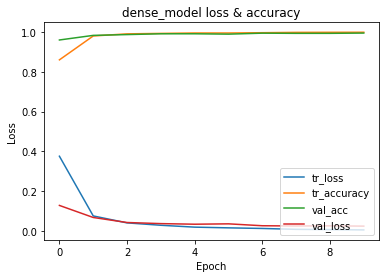

In [49]:

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])


plt.title('dense_model loss & accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['tr_loss', 'tr_accuracy', 'val_acc', 'val_loss'], loc='lower right')
# accuracy!
print("Training results")
print(f"Training Accuracy: {history.history['accuracy'][-1]}")
print(f"Training Loss: {history.history['loss'][-1]}")

# evaluating dense_model
print("Evaluation results")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]}")
print(f"Validation Loss: {history.history['val_loss'][-1]}")


plt.show()